### Задание

1) Модифицируйте код и реализуйте [Wasserstein GAN](https://arxiv.org/abs/1701.07875) ([From GAN to WGAN
](https://lilianweng.github.io/posts/2017-08-20-gan/)) используя weight clipping. (1 балл)

2) Замените  weight clipping на [gradient penalty](https://arxiv.org/pdf/1704.00028v3.pdf). (1 балл)

3) Добавьте к обучению WGAN условие на метку, продемонстрируйте [условную генерацию](https://arxiv.org/pdf/1411.1784.pdf).  (1 балл) 

Напишите отчет о том, что попробовали, какие результаты получили, какую архитектуру использовали, как вам кажется надо обучать GAN, чтобы добиться сходимости? Каждый пункт обязательно сопроводите визуализациями.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch import autograd

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
device

device(type='cuda')

In [3]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.print_freq = 600
config.images_per_epoch = 3

config.batch_size = 32
config.n_critic = 5
config.num_workers = 3
config.num_epochs = 10

config.noise_size = 100
config.g_features_size = 256
config.d_features_size = 256
config.channels_count = 1

config.learning_rate_w = 0.00005
config.clip_value = 0.01

config.learning_rate_gp = 0.0001
config.b1_gp = 0
config.b2_gp = 0.9
config.penatly_coef = 10

config.num_classes = 10
config.embed_size = 50

In [4]:
dataset = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)

# use `config.batch_size * config.n_critic` for following train in `range(config.n_critic)` loop
dataloader = DataLoader(dataset, batch_size=config.batch_size * config.n_critic, shuffle=True)

len(dataloader)

100%|██████████| 26421880/26421880 [00:01<00:00, 14339869.91it/s]


Extracting fashion_mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 212179.91it/s]


Extracting fashion_mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3911829.87it/s]


Extracting fashion_mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 10527682.59it/s]

Extracting fashion_mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



375

In [5]:
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size, 1, 1)).to(device)

In [63]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channels=config.noise_size, out_channels=config.g_features_size*4, 
                               kernel_size=4, stride=1, padding=0),
            nn.ReLU(True),

            # if default case nfg==256, state is 1024x4x4
            nn.ConvTranspose2d(in_channels=config.g_features_size*4, out_channels=config.g_features_size*2, 
                               kernel_size=4, stride=2, padding=1),
            
            nn.ReLU(True),

            # if default case nfg==256, state is 512x8x8
            nn.ConvTranspose2d(in_channels=config.g_features_size*2, out_channels=config.g_features_size, 
                               kernel_size=2, stride=2, padding=1),
            
            nn.ReLU(True),

            # if default case nfg==256, state is 256x14x14
            nn.ConvTranspose2d(in_channels=config.g_features_size, out_channels=config.channels_count, 
                               kernel_size=4, stride=2, padding=1),
            nn.Tanh()
            # output of model --> Image (Cx28x28)
        )
        
    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # Image (Cx28x28)
            nn.Conv2d(in_channels=config.channels_count, out_channels=config.d_features_size, 
                      kernel_size=3, stride=2, padding=1),
            
            nn.LeakyReLU(0.2, inplace=True),

            # if default case ndf==256, state is 256x14x14
            nn.Conv2d(in_channels=config.d_features_size, out_channels=config.d_features_size*2, 
                      kernel_size=2, stride=2, padding=1),
            
            nn.LeakyReLU(0.2, inplace=True),

            # if default case ndf==256, state is 512x8x8
            nn.Conv2d(in_channels=config.d_features_size*2, out_channels=config.d_features_size*4, 
                      kernel_size=4, stride=2, padding=1),
            
            nn.LeakyReLU(0.2, inplace=True),
            
            # The output of D is no longer a probability, we do not apply sigmoid at the output of D.
            # if default case ndf==256, state is 1024x4x4
            nn.Conv2d(in_channels=config.d_features_size*4, out_channels=1, kernel_size=4, stride=1, padding=0)
        )

    def forward(self, x):
        return self.model(x)

In [13]:
import datetime
import time


def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))

    return str(datetime.timedelta(seconds=elapsed_rounded))

In [65]:
def train_G(generator, discriminator, optim_G, G_LOSS, epoch):
    for p in discriminator.parameters():
        p.requires_grad = False
    
    generator.zero_grad()
    noise.data.normal_(0, 1)
    fake = generator(noise)
    output_g = discriminator(fake)
    
    g_loss = -output_g.mean(0).view(1)
    g_loss.backward()
    
    G_LOSS[epoch] += g_loss.item()

    optim_G.step()
    
    return g_loss

In [66]:
def train(generator, discriminator, optim_G, optim_D, train_D):
    G_LOSS = np.zeros(config.num_epochs)
    D_LOSS = np.zeros(config.num_epochs)
    WD = np.zeros(config.num_epochs)

    t_begin = time.time()
    
    generator.train()
    generator.to(device)
    discriminator.train()
    discriminator.to(device)

    for epoch in range(config.num_epochs):
        for iteration, (images, cat) in enumerate(dataloader):           
            d_loss, wd = train_D(discriminator, generator, optim_D, images, cat, D_LOSS, WD, epoch)
            g_loss = train_G(generator, discriminator, optim_G, G_LOSS, epoch)          

            if (iteration+1) % int(config.print_freq / config.n_critic) == 0:
                print(
                    'Time: {} epoch:{} Iter: {} d_loss: {:.2f} g_loss: {:.2f} wd: {:.2f}'.format(
                    format_time(time.time() - t_begin),
                    epoch + 1,
                    (iteration + 1) * config.n_critic, 
                    d_loss.item(),
                    g_loss.item(),
                    wd.item()
                    )
                )            

        noise.data.normal_(0, 1)
        fake = generator(noise)
        
        plt.figure(figsize=(4, 5))
        for i in range(config.images_per_epoch):
            plt.subplot(1, config.images_per_epoch, i + 1)
            
            plt.imshow(fake[i].detach().cpu().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
            plt.axis('off')
        plt.show()

    print("Full time {}".format(format_time(time.time() - t_begin)))
    return G_LOSS, D_LOSS, WD

## Wasserstein GAN with weight clipping

In [67]:
def train_D_w(discriminator, generator, optim_D, images, cat, D_LOSS, WD, epoch):
    for p in discriminator.parameters():
        p.requires_grad = True
    
    for i in range(config.n_critic):
        # splite batches to `config.n_critic` train iterations
        if images.size()[0] >= (i + 1) * config.batch_size:
            current_images = Variable(images[i * config.batch_size: 
                                             (i + 1) * config.batch_size]).to(device)
            
            current_cat = Variable(cat[i * config.batch_size: 
                                       (i + 1) * config.batch_size]).to(device)
            
        else:
            current_images = Variable(images[i * config.batch_size:]).to(device)
            current_cat = Variable(cat[i * config.batch_size:]).to(device)

            # flag that epoch finished
            i = config.n_critic

        if current_images.size()[0] != config.batch_size:
            break

        discriminator.zero_grad()
        
        # weight clipping
        for p in discriminator.parameters():
            p.data.clamp_(-config.clip_value, config.clip_value)

        # real
        output_x = discriminator(current_images)
        
        # fake 
        noise.data.normal_(0, 1)
        fake = generator(noise)
        output_z = discriminator(fake.detach())
        
        # calculate loss
        d_loss = (output_z - output_x).mean(0).view(1)
        d_loss.backward()
        
        D_LOSS[epoch] += d_loss.item()
        
        wd = (output_x - output_z).mean(0).view(1)
        WD[epoch] += wd.item()

        optim_D.step()
    return d_loss, wd

Time: 0:00:20 epoch:1 Iter: 600 d_loss: -7.43 g_loss: 12.04 wd: 7.43
Time: 0:00:39 epoch:1 Iter: 1200 d_loss: -5.52 g_loss: -12.95 wd: 5.52
Time: 0:00:59 epoch:1 Iter: 1800 d_loss: -7.56 g_loss: -29.77 wd: 7.56


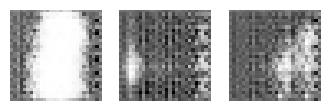

Time: 0:01:21 epoch:2 Iter: 600 d_loss: -7.62 g_loss: -51.21 wd: 7.62
Time: 0:01:41 epoch:2 Iter: 1200 d_loss: -6.86 g_loss: -52.52 wd: 6.86
Time: 0:02:01 epoch:2 Iter: 1800 d_loss: -6.19 g_loss: -10.91 wd: 6.19


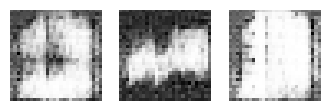

Time: 0:02:23 epoch:3 Iter: 600 d_loss: -4.75 g_loss: -12.07 wd: 4.75
Time: 0:02:43 epoch:3 Iter: 1200 d_loss: -10.69 g_loss: -81.20 wd: 10.69
Time: 0:03:02 epoch:3 Iter: 1800 d_loss: -3.54 g_loss: -38.86 wd: 3.54


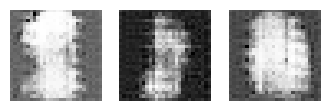

Time: 0:03:25 epoch:4 Iter: 600 d_loss: -0.55 g_loss: -31.41 wd: 0.55
Time: 0:03:44 epoch:4 Iter: 1200 d_loss: -0.58 g_loss: -13.15 wd: 0.58
Time: 0:04:04 epoch:4 Iter: 1800 d_loss: -3.86 g_loss: -48.20 wd: 3.86


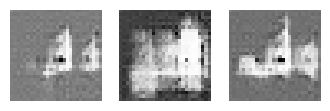

Time: 0:04:26 epoch:5 Iter: 600 d_loss: 4.55 g_loss: -23.96 wd: -4.55
Time: 0:04:46 epoch:5 Iter: 1200 d_loss: -1.49 g_loss: -30.57 wd: 1.49
Time: 0:05:05 epoch:5 Iter: 1800 d_loss: -8.03 g_loss: -72.88 wd: 8.03


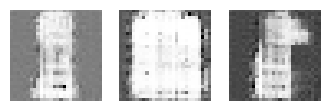

Time: 0:05:27 epoch:6 Iter: 600 d_loss: -2.12 g_loss: -1.62 wd: 2.12
Time: 0:05:47 epoch:6 Iter: 1200 d_loss: 1.54 g_loss: -27.68 wd: -1.54
Time: 0:06:07 epoch:6 Iter: 1800 d_loss: -4.02 g_loss: 6.44 wd: 4.02


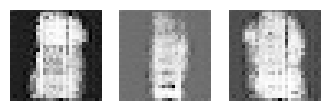

Time: 0:06:29 epoch:7 Iter: 600 d_loss: 0.73 g_loss: -66.93 wd: -0.73
Time: 0:06:49 epoch:7 Iter: 1200 d_loss: 0.53 g_loss: -29.92 wd: -0.53
Time: 0:07:08 epoch:7 Iter: 1800 d_loss: 1.16 g_loss: -51.84 wd: -1.16


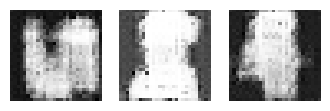

Time: 0:07:31 epoch:8 Iter: 600 d_loss: -6.36 g_loss: 19.89 wd: 6.36
Time: 0:07:50 epoch:8 Iter: 1200 d_loss: -2.41 g_loss: -13.85 wd: 2.41
Time: 0:08:10 epoch:8 Iter: 1800 d_loss: 1.61 g_loss: -71.49 wd: -1.61


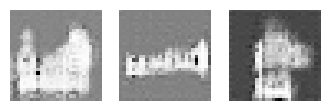

Time: 0:08:32 epoch:9 Iter: 600 d_loss: -3.18 g_loss: -48.48 wd: 3.18
Time: 0:08:52 epoch:9 Iter: 1200 d_loss: -4.77 g_loss: 10.02 wd: 4.77
Time: 0:09:11 epoch:9 Iter: 1800 d_loss: -2.82 g_loss: -61.78 wd: 2.82


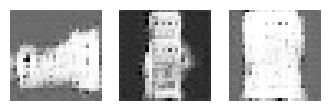

Time: 0:09:33 epoch:10 Iter: 600 d_loss: -2.17 g_loss: -9.07 wd: 2.17
Time: 0:09:53 epoch:10 Iter: 1200 d_loss: -5.28 g_loss: 55.06 wd: 5.28
Time: 0:10:13 epoch:10 Iter: 1800 d_loss: -0.86 g_loss: -2.47 wd: 0.86


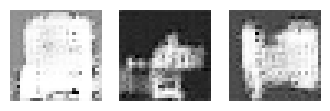

Full time 0:10:15


In [68]:
generator_w = Generator()
discriminator_w = Discriminator()

optim_G_w = optim.RMSprop(
    params=generator_w.parameters(), 
    lr=config.learning_rate_w
)

optim_D_w = optim.RMSprop(
    params=discriminator_w.parameters(), 
    lr=config.learning_rate_w
)

G_W_LOSS, D_W_LOSS, WD_W = train(
    generator_w, 
    discriminator_w, 
    optim_G_w, 
    optim_D_w, 
    train_D_w
)

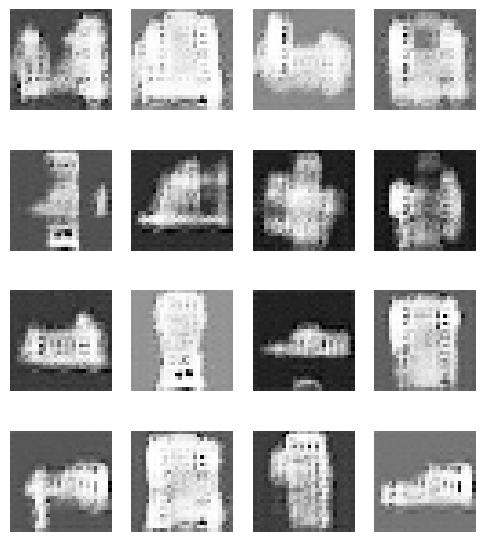

In [69]:
noise.data.normal_(0, 1)
fake = generator_w(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().cpu().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

## Wassertstein GAN with gradient penalty


In [70]:
def calculate_gp(discriminator, real_images, fake_images):
    eta = torch.FloatTensor(real_images.size(0),1,1,1).uniform_(0,1)
    eta = eta.expand(real_images.size()).to(device)

    hat_x = (eta * real_images + ((1 - eta) * fake_images)).to(device)

    hat_x = Variable(hat_x, requires_grad=True)

    output_d = discriminator(hat_x)

    gradients = autograd.grad(
        outputs=output_d, 
        inputs=hat_x,
        grad_outputs=torch.ones(output_d.size()).to(device),
        create_graph=True, 
        retain_graph=True
    )[0]

    grad_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() 
    return grad_penalty * config.penatly_coef

In [71]:
def train_D_gp(discriminator, generator, optim_D, images, cat, D_LOSS, WD, epoch):
    for p in discriminator.parameters():
        p.requires_grad = True
    
    for i in range(config.n_critic):
        # splite batches to `config.n_critic` train iterations
        if images.size()[0] >= (i + 1) * config.batch_size:
            current_images = Variable(images[i * config.batch_size: 
                                             (i + 1) * config.batch_size]).to(device)
            
            current_cat = Variable(cat[i * config.batch_size: 
                                       (i + 1) * config.batch_size]).to(device)
            
        else:
            current_images = Variable(images[i * config.batch_size:]).to(device)
            current_cat = Variable(cat[i * config.batch_size:]).to(device)

            # flag that epoch finished
            i = config.n_critic

        if current_images.size()[0] != config.batch_size:
            break

        discriminator.zero_grad()
        
        # real
        output_x = discriminator(current_images)
        
        # fake 
        noise.data.normal_(0, 1)
        fake = generator(noise)
        output_z = discriminator(fake.detach())
        
        # gradient penalty
        gradient_penalty = calculate_gp(
            discriminator, 
            current_images, 
            fake
        )
        
        # calculate loss
        d_loss = (output_z - output_x).mean(0).view(1) + gradient_penalty
        d_loss.backward()
        
        D_LOSS[epoch] += d_loss.item()
        
        wd = (output_x - output_z).mean(0).view(1)
        WD[epoch] += wd.item()

        optim_D.step()
    return d_loss, wd

Time: 0:00:33 epoch:1 Iter: 600 d_loss: -255.52 g_loss: -649.96 wd: 344.56
Time: 0:01:05 epoch:1 Iter: 1200 d_loss: -153.81 g_loss: -1592.37 wd: 275.83
Time: 0:01:38 epoch:1 Iter: 1800 d_loss: -225.11 g_loss: -1159.86 wd: 331.20


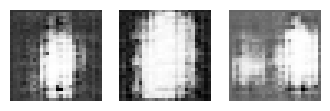

Time: 0:02:15 epoch:2 Iter: 600 d_loss: -155.54 g_loss: -673.88 wd: 236.12
Time: 0:02:47 epoch:2 Iter: 1200 d_loss: -113.12 g_loss: -440.58 wd: 187.39
Time: 0:03:20 epoch:2 Iter: 1800 d_loss: -148.05 g_loss: -859.14 wd: 227.91


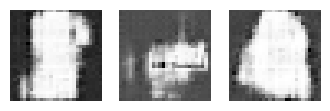

Time: 0:03:57 epoch:3 Iter: 600 d_loss: -41.19 g_loss: -556.98 wd: 101.56
Time: 0:04:29 epoch:3 Iter: 1200 d_loss: -89.29 g_loss: -818.89 wd: 142.57
Time: 0:05:02 epoch:3 Iter: 1800 d_loss: -86.44 g_loss: -280.73 wd: 146.23


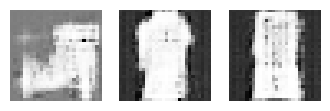

Time: 0:05:39 epoch:4 Iter: 600 d_loss: -103.80 g_loss: -118.12 wd: 160.87
Time: 0:06:11 epoch:4 Iter: 1200 d_loss: -62.34 g_loss: -444.79 wd: 100.36
Time: 0:06:44 epoch:4 Iter: 1800 d_loss: -104.90 g_loss: 60.04 wd: 145.87


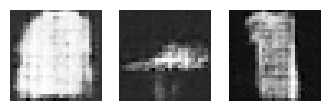

Time: 0:07:21 epoch:5 Iter: 600 d_loss: -84.62 g_loss: -166.86 wd: 123.69
Time: 0:07:53 epoch:5 Iter: 1200 d_loss: -52.96 g_loss: -173.20 wd: 83.18
Time: 0:08:26 epoch:5 Iter: 1800 d_loss: -76.46 g_loss: -64.21 wd: 102.46


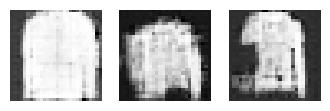

Time: 0:09:03 epoch:6 Iter: 600 d_loss: -84.83 g_loss: 224.25 wd: 119.70
Time: 0:09:35 epoch:6 Iter: 1200 d_loss: -62.43 g_loss: 52.09 wd: 91.19
Time: 0:10:08 epoch:6 Iter: 1800 d_loss: -50.68 g_loss: 3.95 wd: 78.42


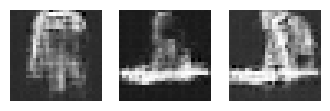

Time: 0:10:45 epoch:7 Iter: 600 d_loss: -79.24 g_loss: 59.90 wd: 111.40
Time: 0:11:17 epoch:7 Iter: 1200 d_loss: -39.50 g_loss: -39.74 wd: 66.38
Time: 0:11:50 epoch:7 Iter: 1800 d_loss: -64.78 g_loss: -70.85 wd: 88.20


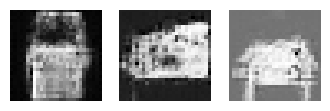

Time: 0:12:27 epoch:8 Iter: 600 d_loss: -55.90 g_loss: 202.52 wd: 80.57
Time: 0:12:59 epoch:8 Iter: 1200 d_loss: -52.06 g_loss: 140.47 wd: 75.84
Time: 0:13:32 epoch:8 Iter: 1800 d_loss: -82.55 g_loss: 6.95 wd: 107.14


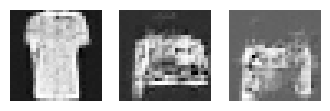

Time: 0:14:09 epoch:9 Iter: 600 d_loss: -43.49 g_loss: 159.73 wd: 68.06
Time: 0:14:42 epoch:9 Iter: 1200 d_loss: -44.21 g_loss: 292.62 wd: 69.78
Time: 0:15:14 epoch:9 Iter: 1800 d_loss: -36.73 g_loss: 219.45 wd: 60.61


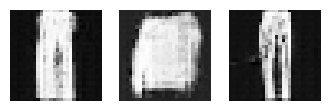

Time: 0:15:51 epoch:10 Iter: 600 d_loss: -81.97 g_loss: 476.95 wd: 108.02
Time: 0:16:24 epoch:10 Iter: 1200 d_loss: -37.85 g_loss: 267.02 wd: 58.09
Time: 0:16:56 epoch:10 Iter: 1800 d_loss: -55.89 g_loss: 225.49 wd: 79.89


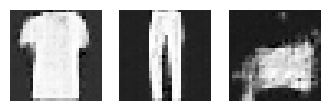

Full time 0:17:00


In [72]:
generator_gp = Generator()
discriminator_gp = Discriminator()

optim_G_gp = optim.Adam(
    generator_gp.parameters(), 
    lr=config.learning_rate_gp, 
    betas=(config.b1_gp, config.b2_gp)
)

optim_D_gp = optim.Adam(
    discriminator_gp.parameters(), 
    lr=config.learning_rate_gp, 
    betas=(config.b1_gp, config.b2_gp)
)

G_GP_LOSS, D_GP_LOSS, WD_GP = train(
    generator_gp,
    discriminator_gp, 
    optim_G_gp, 
    optim_D_gp, 
    train_D_gp
)

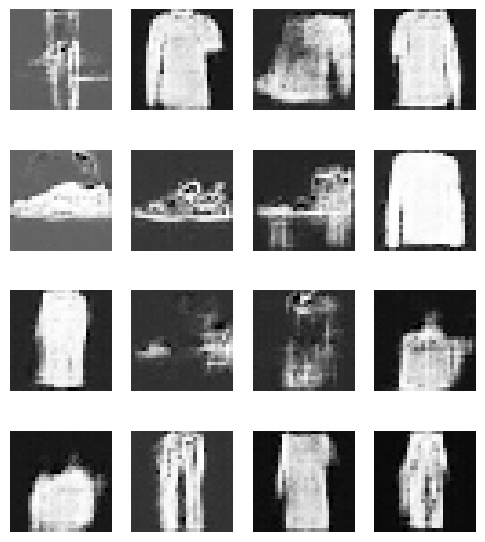

In [73]:
noise.data.normal_(0, 1)
fake = generator_gp(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().cpu().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

1. I found out that the best quality images are generated after about 8-10 epochs  
2. Using of batchNorm is not good idea. With batch_size == 32 the best results are generated by model without BatchNorm  
3. Gradient penalty is very good method to get 1-Lipschitz function. WGAN with GP is significantly better


Использовались разные значения лямбды, при 13 лучшее качество было после 13-15 эпох  
Для 7 качество было не особо хорошее  
Если для W применить Adam с параметрами gp то модель очень плохо обучится

## Conditional generation using Wassertstein GAN with gradient penalty

In [6]:
fake_labels = Variable(torch.IntTensor(config.batch_size)).to(device)

In [7]:
class ConditionalGenerator(nn.Module):
    def __init__(self,):
        super(ConditionalGenerator, self).__init__()
        
        self.embed = nn.Embedding(config.num_classes, config.embed_size)
        
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channels=config.noise_size + config.embed_size, out_channels=config.g_features_size*4, 
                               kernel_size=4, stride=1, padding=0),
            nn.ReLU(True),

            # if default case g_features_size==256, state is 1024x4x4
            nn.ConvTranspose2d(in_channels=config.g_features_size*4, out_channels=config.g_features_size*2, 
                               kernel_size=4, stride=2, padding=1),
            
            nn.ReLU(True),

            # if default case g_features_size==256, state is 512x8x8
            nn.ConvTranspose2d(in_channels=config.g_features_size*2, out_channels=config.g_features_size, 
                               kernel_size=2, stride=2, padding=1),
            
            nn.ReLU(True),

            # if default case g_features_size==256, state is 256x14x14
            nn.ConvTranspose2d(in_channels=config.g_features_size, out_channels=config.channels_count, 
                               kernel_size=4, stride=2, padding=1),
            nn.Tanh()
            # output of model --> Image (Cx28x28)
        )
        
    def forward(self, x, y):
        y = self.embed(y).unsqueeze(2).unsqueeze(3)
        return self.model(torch.cat((x, y), dim=1))
    
class ConditionalDiscriminator(nn.Module):
    def __init__(self):
        super(ConditionalDiscriminator, self).__init__()
        
        self.embed = nn.Embedding(config.num_classes, 28*28)
        
        self.model = nn.Sequential(
            # Image ((C+1)x28x28)
            nn.Conv2d(in_channels=config.channels_count + 1, out_channels=config.d_features_size, 
                      kernel_size=3, stride=2, padding=1),
            
            nn.LeakyReLU(0.2, inplace=True),

            # if default case d_features_size==256, state is 256x14x14
            nn.Conv2d(in_channels=config.d_features_size, out_channels=config.d_features_size*2, 
                      kernel_size=2, stride=2, padding=1),
            
            nn.LeakyReLU(0.2, inplace=True),

            # if default case d_features_size==256, state is 512x8x8
            nn.Conv2d(in_channels=config.d_features_size*2, out_channels=config.d_features_size*4, 
                      kernel_size=4, stride=2, padding=1),
            
            nn.LeakyReLU(0.2, inplace=True),
            
            # The output of D is no longer a probability, we do not apply sigmoid at the output of D.
            # if default case d_features_size==256, state is 1024x4x4
            nn.Conv2d(in_channels=config.d_features_size*4, out_channels=1, kernel_size=4, stride=1, padding=0)
        )

    def forward(self, x, y):
        y = self.embed(y).view(y.shape[0], 1, 28, 28)
        return self.model(torch.cat((x, y), dim=1)) # N x (C+1) x H x W

In [8]:
def calculate_cond_gp(discriminator, labels, real_images, fake_images):
    eta = torch.FloatTensor(real_images.size(0),1,1,1).uniform_(0,1)
    eta = eta.expand(real_images.size()).to(device)

    hat_x = (eta * real_images + ((1 - eta) * fake_images)).to(device)

    hat_x = Variable(hat_x, requires_grad=True)

    output_d = discriminator(hat_x, labels)

    gradients = autograd.grad(
        outputs=output_d, 
        inputs=hat_x,
        grad_outputs=torch.ones(output_d.size()).to(device),
        create_graph=True, 
        retain_graph=True
    )[0]

    grad_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() 
    return grad_penalty * config.penatly_coef

In [9]:
def train_CD_gp(discriminator, generator, optim_D, images, cat, D_LOSS, WD, epoch):
    for p in discriminator.parameters():
        p.requires_grad = True
    
    for i in range(config.n_critic):
        # splite batches to `config.n_critic` train iterations
        if images.size()[0] >= (i + 1) * config.batch_size:
            
            current_images = Variable(images[i * config.batch_size:
                                             (i + 1) * config.batch_size]).to(device)
            
            current_cat = Variable(cat[i * config.batch_size: 
                                       (i + 1) * config.batch_size]).to(device)
            
            
        else:
            current_images = Variable(images[i * config.batch_size:]).to(device)
                                      
            current_cat = Variable(cat[i * config.batch_size:]).to(device)

            # flag that epoch finished
            i = config.n_critic

        if current_images.size()[0] != config.batch_size:
            break

        discriminator.zero_grad()
        
        # real
        output_x = discriminator(current_images, current_cat)
    
        # fake 
        noise.data.normal_(0, 1)

        fake_images = generator(noise, current_cat)
        output_z = discriminator(fake_images.detach(), current_cat)
        
        gradient_penalty = calculate_cond_gp(
            discriminator, 
            current_cat, 
            current_images, 
            fake_images
        )
        
        d_loss = (output_z - output_x).mean(0).view(1) + gradient_penalty
        d_loss.backward()
        
        D_LOSS[epoch] += d_loss.item()
        
        wd = (output_x - output_z).mean(0).view(1)
        WD[epoch] += wd.item()

        optim_D.step()
    return d_loss, wd

In [10]:
def train_CG(generator, discriminator, optim_G, G_LOSS, epoch):
    for p in discriminator.parameters():
        p.requires_grad = False
    
    generator.zero_grad()
    noise.data.normal_(0, 1)
    fake_labels.data = torch.randint(0, 10, (config.batch_size,)).to(device)
    
    fake = generator(noise, fake_labels)
    output_g = discriminator(fake, fake_labels)
    
    g_loss = -output_g.mean(0).view(1)
    g_loss.backward()
    
    G_LOSS[epoch] += g_loss.item()

    optim_G.step()
    
    return g_loss

In [11]:
def cond_train(generator, discriminator, optim_G, optim_D, train_D):
    G_LOSS = np.zeros(config.num_epochs)
    D_LOSS = np.zeros(config.num_epochs)
    WD = np.zeros(config.num_epochs)

    t_begin = time.time()
    
    generator.train()
    generator.to(device)
    discriminator.train()
    discriminator.to(device)

    for epoch in range(config.num_epochs):
        for iteration, (images, cat) in enumerate(dataloader):           
            d_loss, wd = train_D(discriminator, generator, optim_D, images, cat, D_LOSS, WD, epoch)
            g_loss = train_CG(generator, discriminator, optim_G, G_LOSS, epoch)          

            if (iteration+1) % int(config.print_freq / config.n_critic) == 0:
                print(
                    'Time: {} epoch:{} Iter: {} d_loss: {:.2f} g_loss: {:.2f} wd: {:.2f}'.format(
                    format_time(time.time() - t_begin),
                    epoch + 1,
                    (iteration + 1) * config.n_critic, 
                    d_loss.item(),
                    g_loss.item(),
                    wd.item()
                    )
                )            

        noise.data.normal_(0, 1)
        fake_labels.data = torch.randint(0, 10, (config.batch_size,)).to(device)
    
        fake = generator(noise, fake_labels)
        
        plt.figure(figsize=(4, 5))
        for i in range(config.images_per_epoch):
            plt.subplot(1, config.images_per_epoch, i + 1)
            plt.title(f"{fake_labels[i].cpu().item()}")
            plt.imshow(fake[i].detach().cpu().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
            plt.axis('off')
        plt.show()


    print("Full time {}".format(format_time(time.time() - t_begin)))
    return G_LOSS, D_LOSS, WD

Time: 0:00:39 epoch:1 Iter: 600 d_loss: -35.07 g_loss: -140.25 wd: 45.98
Time: 0:01:13 epoch:1 Iter: 1200 d_loss: -49.77 g_loss: -184.29 wd: 60.48
Time: 0:01:46 epoch:1 Iter: 1800 d_loss: -32.23 g_loss: -0.21 wd: 42.67


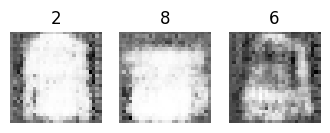

Time: 0:02:24 epoch:2 Iter: 600 d_loss: -45.26 g_loss: -381.38 wd: 56.61
Time: 0:02:57 epoch:2 Iter: 1200 d_loss: -83.45 g_loss: -559.91 wd: 101.88
Time: 0:03:31 epoch:2 Iter: 1800 d_loss: -75.01 g_loss: -1059.87 wd: 108.66


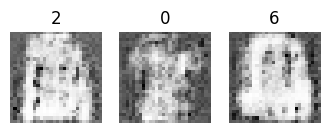

Time: 0:04:08 epoch:3 Iter: 600 d_loss: -69.89 g_loss: -242.09 wd: 88.36
Time: 0:04:42 epoch:3 Iter: 1200 d_loss: -41.39 g_loss: -227.97 wd: 56.25
Time: 0:05:15 epoch:3 Iter: 1800 d_loss: -34.80 g_loss: -325.53 wd: 46.00


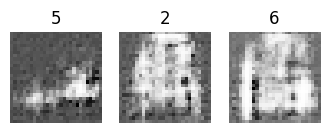

Time: 0:05:53 epoch:4 Iter: 600 d_loss: 6.47 g_loss: -557.46 wd: 12.83
Time: 0:06:26 epoch:4 Iter: 1200 d_loss: -55.60 g_loss: -23.20 wd: 73.26
Time: 0:06:59 epoch:4 Iter: 1800 d_loss: -40.01 g_loss: -587.71 wd: 51.43


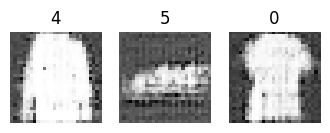

Time: 0:07:37 epoch:5 Iter: 600 d_loss: -45.20 g_loss: -656.05 wd: 57.86
Time: 0:08:10 epoch:5 Iter: 1200 d_loss: -33.98 g_loss: -1048.54 wd: 54.28
Time: 0:08:44 epoch:5 Iter: 1800 d_loss: -14.73 g_loss: -710.71 wd: 29.87


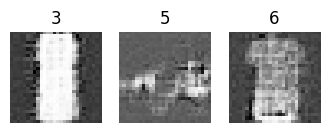

Time: 0:09:21 epoch:6 Iter: 600 d_loss: -60.65 g_loss: -1018.15 wd: 72.91
Time: 0:09:55 epoch:6 Iter: 1200 d_loss: -37.25 g_loss: -542.94 wd: 47.97
Time: 0:10:28 epoch:6 Iter: 1800 d_loss: -27.08 g_loss: -436.65 wd: 37.10


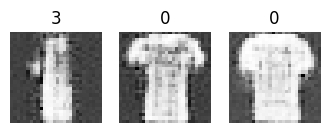

Time: 0:11:06 epoch:7 Iter: 600 d_loss: -22.85 g_loss: -726.89 wd: 32.52
Time: 0:11:39 epoch:7 Iter: 1200 d_loss: -30.85 g_loss: -591.40 wd: 45.30
Time: 0:12:13 epoch:7 Iter: 1800 d_loss: -32.18 g_loss: -317.23 wd: 41.58


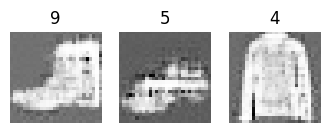

Time: 0:12:51 epoch:8 Iter: 600 d_loss: -44.65 g_loss: 305.60 wd: 58.64
Time: 0:13:24 epoch:8 Iter: 1200 d_loss: -28.62 g_loss: -74.97 wd: 38.54
Time: 0:13:57 epoch:8 Iter: 1800 d_loss: -6.21 g_loss: -139.52 wd: 16.33


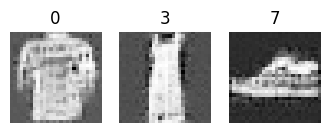

Time: 0:14:35 epoch:9 Iter: 600 d_loss: -36.08 g_loss: 95.57 wd: 47.02
Time: 0:15:09 epoch:9 Iter: 1200 d_loss: -66.94 g_loss: -663.08 wd: 79.55
Time: 0:15:42 epoch:9 Iter: 1800 d_loss: -28.58 g_loss: -292.62 wd: 36.26


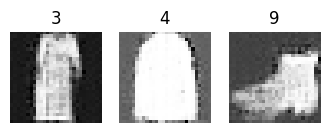

Time: 0:16:20 epoch:10 Iter: 600 d_loss: -31.51 g_loss: -216.60 wd: 40.71
Time: 0:16:53 epoch:10 Iter: 1200 d_loss: -22.85 g_loss: -222.45 wd: 32.79
Time: 0:17:27 epoch:10 Iter: 1800 d_loss: -24.43 g_loss: -76.25 wd: 33.03


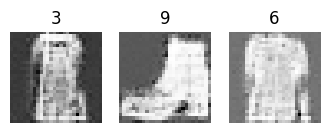

Full time 0:17:31


In [14]:
cond_generator_gp = ConditionalGenerator()
cond_discriminator_gp = ConditionalDiscriminator()

optim_CG_gp = optim.Adam(
    cond_generator_gp.parameters(), 
    lr=config.learning_rate_gp, 
    betas=(config.b1_gp, config.b2_gp)
)

optim_CD_gp = optim.Adam(
    cond_discriminator_gp.parameters(), 
    lr=config.learning_rate_gp, 
    betas=(config.b1_gp, config.b2_gp)
)

CG_GP_LOSS, CD_GP_LOSS, C_WD_GP = cond_train(
    cond_generator_gp,
    cond_discriminator_gp, 
    optim_CG_gp, 
    optim_CD_gp, 
    train_CD_gp
)

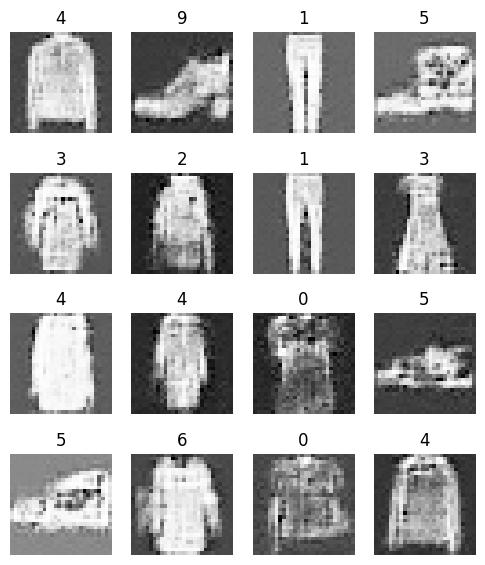

In [15]:
noise.data.normal_(0, 1)
fake_labels.data = torch.randint(0, 10, (config.batch_size,)).to(device)
    
fake = cond_generator_gp(noise, fake_labels)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.title(f"{fake_labels[i].cpu().item()}")
    plt.imshow(fake[i].detach().cpu().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

Classes of FashiomMNIST:

0. T-shirt/top  
1. Trouser  
2. Pullover  
3. Dress  
4. Coat  
5. Sandal  
6. Shirt  
7. Sneaker  
8. Bag  
9. Ankle boot

I started train my WGAN with emb_size == 100, after it I used 50. In this case quality of generator was getting better. But with emb_size == 10 or 1, WGAN didn't look at the condition (I used 10 epochs)